Defino las variables de entorno

In [12]:
USER_FLAG = "--user"

REGION="us-east4"
REGION="us-central1"

# Get projet name
shell_output=!gcloud config get-value project 2> /dev/null
PROJECT_ID=shell_output[0]
print("Project ID:", PROJECT_ID)

#if (
#    SERVICE_ACCOUNT == ""
#    or SERVICE_ACCOUNT is None
3    or SERVICE_ACCOUNT == "[your-service-account]"
#):
# Get your GCP project id from gcloud
shell_output = !gcloud auth list 2>/dev/null
SERVICE_ACCOUNT = shell_output[2].strip()
print("Service Account:", SERVICE_ACCOUNT)

# Set bucket name
#BUCKET_NAME="gs://"+PROJECT_ID+"-encuestas_nps"
BUCKET_NAME="gs://speech_analytics_bucket"
#print(BUCKET_NAME)
# Create pipeline 
PIPELINE_ROOT = f"{BUCKET_NAME}/pipelines/"
print(PIPELINE_ROOT)


# API service endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
print(API_ENDPOINT)



Project ID: teco-dev-sa-ccdd-b016
Service Account: *       z002162@teco-dev-sa-ccdd-b016.iam.gserviceaccount.com
gs://speech_analytics_bucket/pipelines/
us-central1-aiplatform.googleapis.com


#### El primer paso es instalar / cargar las librerias de Kubeflow y de vertex pipelines (Este pipeline funciona con la version 1.8.22 o menor)

In [13]:
#!pip install google-cloud-aiplatform==1.26.1
#!pip install google-cloud-pipeline-components==1.0.44
#!pip install kfp==1.8.22

import kfp
from typing import NamedTuple

from kfp.v2 import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import pipeline, component, Artifact, Dataset, Input, Metrics, Model, Output, ClassificationMetrics, OutputPath

from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs
import google.cloud.aiplatform as aip
from google_cloud_pipeline_components import aiplatform as gcc_aip
from datetime import datetime, timedelta
import json 

Esquema de los componentes que se van a crear:
- Pipeline que obtiene datos de BQ, entrena un modelo de sklearn (Random Forest) y un Xgboost. Testea ambos modelos y si las metricas superan un umbral del deploya, en un caso a un endpoint y en otro a un bucket de gcp 

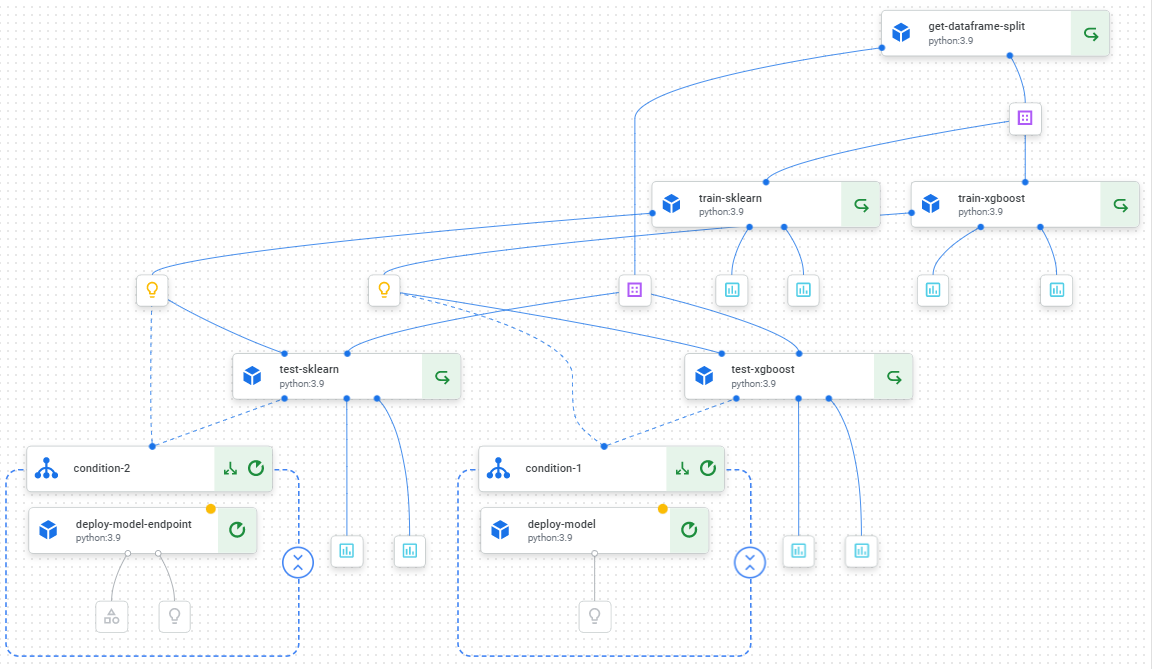

In [34]:
from IPython.display import Image
Image("img/pipeline-train-test-deploy.png")

## 1er Componente - Levanta los datos y splitea

In [14]:
# en el decorador se setea los parametros para crear el contenedor
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0","db_dtypes==1.1.1","scikit-learn==1.2.0","fastparquet==2023.1.0"],
    base_image="python:3.9",
    #output_component_file="./artifacts/get_dataframe.yaml" #aqui podria definir un lugar para guardar el componente (para reutilizarlo a futuro)
)

def get_dataframe_split(
        query_string: str,
        project_id: str,
        #dataset: Output[Dataset],
        dataset_train: Output[Dataset],
        dataset_test: Output[Dataset],
        min_df_len: int= 1,
        test_size: float = 0.25
        
):
    """
    Descarga el dataset desde BigQuery y lo guarda en formato csv o parquet según se defina el parámetro dataset_format.
    Inputs: 
    - query_string: string con la query que obtiene el dataset
    - project_id: id del proyecto de GCP
    - min_df_len: int si el dataframe es mas corto que este parametro, el pipeline se detiene y se da un aviso. 
    - test_size: percentage of test dataset
    
    Outputs:
    - dataset_train: el dataset almacenado para poder enviarlo a otro componente
    - dataset_test: el dataset almacenado para poder enviarlo a otro componente
    """
    

    from google.cloud import bigquery
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    import logging

    bqclient = bigquery.Client(project=project_id)
    
    job_config = bigquery.QueryJobConfig()
    
    df = (bqclient.query(query_string, job_config=job_config).result().to_dataframe(create_bqstorage_client=False))
    
    train, test = train_test_split(df, test_size=test_size) 

    # guardado de archivos, preprocessed_train & preprocessed_test son objetos "Output"
    
    train.to_csv(dataset_train.path + ".csv", index=False, encoding='utf-8-sig')
    test.to_csv(dataset_test.path + ".csv" , index=False, encoding='utf-8-sig')
    logging.info("Guardado como csv")

    if len(df) <= min_df_len:
        raise Exception(f"El DataFrame resultante es demasiado corto (tamaño = {len(df)}). Se requiere un tamaño mínimo de {min_df_len}.")
    logging.info(df.dtypes)    
    logging.info(query_string)

    

## 2do-A Componente - Entrenamiento SKLEARN

In [15]:
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0", "db_dtypes==1.1.1",
                         "scikit-learn==1.2.0", "scipy==1.11.4"],
    base_image="python:3.9",
)
def train_sklearn(
    train_set: Input[Dataset],
    predictors_variables: list,
    target_variable: list,
    model: Output[Model],
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics],
) -> NamedTuple("Outputs", [("model_gs_uri", str), ("best_model", str) , ("best_params", dict)]):
    """
    Componente para entrenar un RandomForest recibiendo un parquet:
    Inputs:
    - Dataset: Dataset en formato parquet dentro de un objeto de tipo Input[Dataset],
    recibido del componente anterior
    - predictors_variables: lista con los nombres de las columnas que se utilizaran como predictoras
    - target_variable: lista con la/s variable/s objetivos
    - model: [ ingresa como parametro, es la salida del archivo del modelo en formato .pkl]
    - metrics: Metricas que evaluan el entrenamiento
    - kpi: kpis que evaluan el entrenamiento
    - model_gs_uri: uri al modelo almacenado en el storage
    """

    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn import metrics as skl_metrics
    import pickle
    import logging


    data = pd.read_csv(train_set.path + ".csv")

    X = data[predictors_variables].copy()
    logging.info("Columnas a predictoras: ")
    logging.info(X.columns)
    logging.info(f"Se usaran {X.shape[1]} columnas predictoras")

    # Check if the target variable is provided, otherwise use a default

    y = data[target_variable[0]].copy()
    logging.info(print(y))
    
    
    
    # Specify classifiers and their respective hyperparameter spaces
    classifiers = {
    'RandomForest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'min_samples_split': [4, 8, 16], 'min_samples_leaf': [2, 4, 8], 'bootstrap': [True, False]}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'DecisionTree': (DecisionTreeClassifier(), {'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
    }
    
    
    # Iterate over classifiers and perform randomized search
    for clf_name, (clf, param_dist) in classifiers.items():
        logging.info(f"Running RandomizedSearchCV for {clf_name}")
        random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=3, cv=3, random_state=1977, verbose=True)
        random_search.fit(X, y)
    
    
    ####USE ONLY ONE ALGORITHM#### 
    
    #params_dict = {'n_estimators': [10, 50, 100],  # You can customize this list with the values you want to test
    #'min_samples_split': [4, 8, 16],
    #'min_samples_leaf': [2, 4, 8],
    #'bootstrap': [True, False]}
    
    #rf = RandomForestClassifier()
    #random_search = RandomizedSearchCV(estimator=rf, param_distributions=params_dict, n_iter=3, cv=2, random_state=1977, verbose=True)
    
    #random_search.fit(X, y)
    
    
    
    
    
    # ESTO ES PARA REUTILIZAR LA MISMA LOGICA
    model_trained = random_search.best_estimator_

    model_trained.fit(X, y)

    y_pred = model_trained.predict(X)
    y_scores = model_trained.predict_proba(X)[:, 1]

    fpr, tpr, thresholds = skl_metrics.roc_curve(y_true=y, y_score=y_scores, pos_label=True)

    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())

    # CALCULO LAS METRICAS
    accuracy = skl_metrics.accuracy_score(y, y_pred.round())
    recall = skl_metrics.recall_score(y, y_pred.round(), zero_division=0, average='weighted')
    precision = skl_metrics.precision_score(y, y_pred.round(), average='weighted')
    f1_score = skl_metrics.f1_score(y, y_pred.round(), average='weighted')
    logging.info(print(accuracy))
    logging.info(print(recall))
    logging.info(print(precision))
    logging.info(print(f1_score))
    
    # LAS GUARDO
    kpi.log_metric("accuracy", float(accuracy))
    kpi.log_metric("recall", float(recall))
    kpi.log_metric("precision", float(precision))
    kpi.log_metric("f1_score", float(f1_score))

    model.metadata["framework"] = "Random Search SKLEARN"
    file_name = model.path + ".pkl"
    with open(file_name, 'wb') as file:
        pickle.dump(model_trained, file)

    logging.info(model.uri + ".pkl")
    return model.uri + ".pkl", str(random_search.estimator), random_search.best_params_

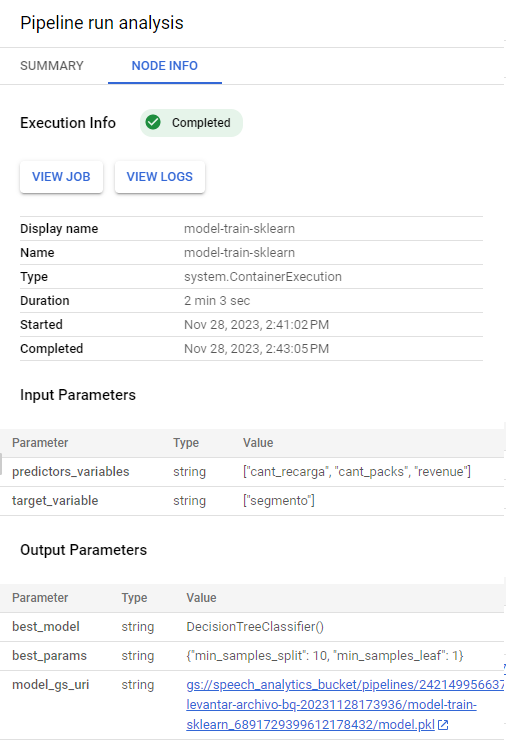

In [1]:
from IPython.display import Image
Image("img/model-train-sklearn.png")

## 2do-B Componente - Entrenamiento XGBOOST

In [16]:
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0", "db_dtypes==1.1.1",
                         "scikit-learn==1.2.0", "scipy==1.11.4","xgboost==1.7.3"],
    base_image="python:3.9",
)


def train_xgboost(
    train_set: Input[Dataset],
    predictors_variables: list,
    target_variable: list,
    model: Output[Model],
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics],
) -> NamedTuple("Outputs", [("model_gs_uri", str), ("best_params", dict)]):
    """
    Componente para entrenar un RandomForest recibiendo un parquet:
    Inputs:
    - Dataset: Dataset en formato parquet dentro de un objeto de tipo Input[Dataset],
    recibido del componente anterior
    - predictors_variables: lista con los nombres de las columnas que se utilizaran como predictoras
    - target_variable: lista con la/s variable/s objetivos
    - model: [ ingresa como parametro, es la salida del archivo del modelo en formato .pkl]
    - metrics: Metricas que evaluan el entrenamiento
    - kpi: kpis que evaluan el entrenamiento
    - model_gs_uri: uri al modelo almacenado en el storage
    """

    import pandas as pd
    from sklearn.model_selection import RandomizedSearchCV
    from xgboost import XGBClassifier
    from sklearn import metrics as skl_metrics
    import pickle
    import numpy as np
    import logging

    data = pd.read_csv(train_set.path + ".csv")

    X = data[predictors_variables].copy()
    logging.info("Columnas a predictoras: ")
    logging.info(X.columns)
    logging.info(f"Se usaran {X.shape[1]} columnas predictoras")

    # Check if the target variable is provided, otherwise use a default

    y = data[target_variable[0]].copy()
    logging.info(print(y))
    
    # Define the XGBoost model
    xgb_model = XGBClassifier()

    
    
    
    # Define the hyperparameter grid for random search
    param_dist = {
    'n_estimators': [1,2,3],
    'max_depth': [3,4,5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
    }

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=3, cv=3, random_state=1977, verbose=True)


    # Fit the GridSearchCV object to the data
    random_search.fit(X, y)

    # Get the best hyperparameters from the grid search
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    
    # ESTO ES PARA REUTILIZAR LA MISMA LOGICA
    model_trained = random_search.best_estimator_

    model_trained.fit(X, y)

    y_pred = model_trained.predict(X)
    y_scores = model_trained.predict_proba(X)[:, 1]

    fpr, tpr, thresholds = skl_metrics.roc_curve(y_true=y, y_score=y_scores, pos_label=True)

    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())

    # CALCULO LAS METRICAS
    accuracy = skl_metrics.accuracy_score(y, y_pred.round())
    recall = skl_metrics.recall_score(y, y_pred.round(), zero_division=0, average='weighted')
    precision = skl_metrics.precision_score(y, y_pred.round(), average='weighted')
    f1_score = skl_metrics.f1_score(y, y_pred.round(), average='weighted')
    logging.info(print(accuracy))
    logging.info(print(recall))
    logging.info(print(precision))
    logging.info(print(f1_score))
    
    # LAS GUARDO
    kpi.log_metric("accuracy", float(accuracy))
    kpi.log_metric("recall", float(recall))
    kpi.log_metric("precision", float(precision))
    kpi.log_metric("f1_score", float(f1_score))

    
    model.metadata["framework"] = "Random Search XGBoost"
    file_name = model.path + f".bst"
    model_trained.save_model(file_name)
    
    return (model.uri+ f".bst",random_search.best_params_)
    #return model.uri + ".pkl", str(random_search.estimator), random_search.best_params_


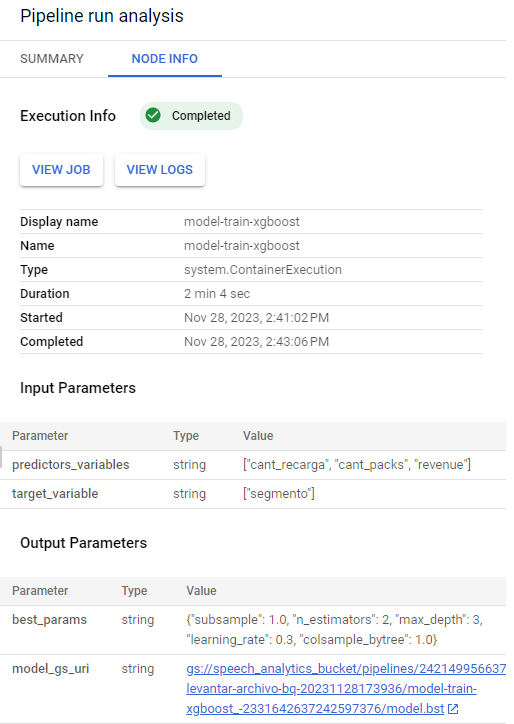

In [35]:
from IPython.display import Image
Image("img/model-train-xgboost.png")

## 3er Componente - Evaluación - SKLEARN

In [17]:
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0", "db_dtypes==1.1.1","scikit-learn==1.2.0", "scipy==1.11.4"],
    base_image="python:3.9",
)

def test_sklearn(
    test_set: Input[Dataset],
    model_trained: Input[Model],
    predictors_variables: list,
    target_variable: list,
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics],
    thresholds_dict: dict = {"accuracy" : 0.0, "precision" : 0.0, "recall" : 0.0, "f1_score" : 0.0},
) -> NamedTuple("Outputs", [("performance", dict), ("deploy", str)]): 


    


    """
    Component for evaluating the performance of a scikit-learn classification model:
    Inputs:
    - test_set: Dataset in csv format within an Input[Dataset] object
    - model: Input[Model], contains the path of the model file
    - predictors_variables: list of column names that will be used as predictors
    - target_variable: string with the name of the target variable
    Outputs
    - metrics: Output[ClassificationMetrics]
    """

    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn import metrics as skl_metrics
    import pickle
    import numpy as np
    import logging
    

    def threshold_check(val1, val2):
        cond = "false"
        if val1 >= val2 :
            cond = "true"
        return cond

    def threshold_check(thresholds_dict, accuracy, recall,precision,f1_score ):
        cond = "true"
        for metric, value in thresholds_dict.items():
            if metric == "accuracy":
                if float(value) > float(accuracy):
                    cond = "false"
            elif metric == "recall":
                if float(value) > float(recall):
                    cond  = "false"
            elif metric == "precision":
                if float(value) > float(precision):
                    cond  = "false"
            elif metric == "f1_score":
                if float(value) > float(f1_score):
                    cond  = "false"
        return cond      
        
    data = pd.read_csv(test_set.path+".csv")
    
    X_test =  data[predictors_variables].copy()
    logging.info("Columnas a predictoras: ")
    logging.info(X_test.columns)
    logging.info(f"Se usaran { X_test.shape[1]} columnas predictoras")
    
    y_test = data[target_variable[0]].copy()
    
    
    file_name = model_trained.path + f".pkl"
    # load the model from disk
    #model.load_model(file_name)  # load data
    model = pickle.load(open(file_name, 'rb'))
    
    
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = skl_metrics.roc_curve(y_true=y_test, y_score=y_scores, pos_label=True)
    
    
    #labels = np.unique(np.concatenate([y_test, y_pred]))
    labels = np.unique(y_test)
    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())
    #metrics.log_confusion_matrix( labels  ,skl_metrics.confusion_matrix(y_test, y_pred,labels=labels ).tolist()) 
    
    
    # CALCULO LAS METRICAS
    accuracy = skl_metrics.accuracy_score(y_test, y_pred.round())
    recall = skl_metrics.recall_score(y_test, y_pred.round() ,zero_division=0, average='weighted'  )# , labels=np.unique(y_pred) )
    precision = skl_metrics.precision_score(y_test, y_pred.round() , average='weighted')# , labels=np.unique(y_pred) )
    f1_score = skl_metrics.f1_score(y_test, y_pred.round()  , average='weighted')  # , labels=np.unique(y_pred) )

    model_trained.metadata["accuracy"] = float(accuracy)
    model_trained.metadata["recall"] = float(recall)
    model_trained.metadata["precision"] = float(precision)
    model_trained.metadata["f1_score"] = float(f1_score)
    
    
    ####LAS GUARDO####
    kpi.log_metric("accuracy", float(accuracy))
    kpi.log_metric("recall", float(recall))
    kpi.log_metric("precision", float(precision))
    kpi.log_metric("f1_score", float(f1_score))
    
    recall = float(recall)
    precision = float(precision)
    accuracy = float(accuracy)
    f1_score = float(f1_score)
     
    # Create a dictionary
    performance = {'recall': recall,'precision': precision,'accuracy': accuracy,'f1_score': f1_score}

    deploy = threshold_check(thresholds_dict,float(accuracy),float(recall),float(precision),float(f1_score))
    
    return (performance, deploy)




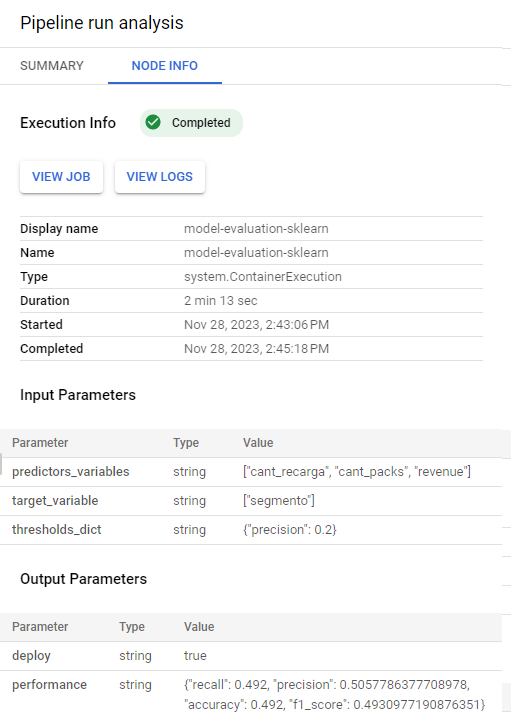

In [36]:
from IPython.display import Image
Image("img/model-evaluation-sklearn.png")

## 3er Componente - Evaluación - XGBOOST

In [29]:
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0", "pandas==1.5.2", "pyarrow==7.0.0", "db_dtypes==1.1.1","scikit-learn==1.2.0", "scipy==1.11.4","joblib==1.2.0","xgboost==1.7.3"],
    base_image="python:3.9",
)

def test_xgboost(
    test_set: Input[Dataset],
    model_trained: Input[Model],
    predictors_variables: list,
    target_variable: list,
    best_params: dict, 
    metrics: Output[ClassificationMetrics],
    kpi: Output[Metrics],
    thresholds_dict: dict = {"accuracy" : 0.0, "precision" : 0.0, "recall" : 0.0, "f1_score" : 0.0},
) -> NamedTuple("Outputs", [("performance", dict), ("deploy", str)]): 


    """
    Component for evaluating the performance of a scikit-learn classification model:
    Inputs:
    - test_set: Dataset in csv format within an Input[Dataset] object
    - model: Input[Model], contains the path of the model file
    - predictors_variables: list of column names that will be used as predictors
    - target_variable: string with the name of the target variable
    Outputs
    - metrics: Output[ClassificationMetrics]
    """

    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn import metrics as skl_metrics
    import pickle
    import numpy as np
    import logging
    import joblib
    

    def threshold_check(val1, val2):
        cond = "false"
        if val1 >= val2 :
            cond = "true"
        return cond

    def threshold_check(thresholds_dict, accuracy, recall,precision,f1_score ):
        cond = "true"
        for metric, value in thresholds_dict.items():
            if metric == "accuracy":
                if float(value) > float(accuracy):
                    cond = "false"
            elif metric == "recall":
                if float(value) > float(recall):
                    cond  = "false"
            elif metric == "precision":
                if float(value) > float(precision):
                    cond  = "false"
            elif metric == "f1_score":
                if float(value) > float(f1_score):
                    cond  = "false"
        return cond      
        
    data = pd.read_csv(test_set.path+".csv")
    
    X_test =  data[predictors_variables].copy()
    logging.info("Columnas a predictoras: ")
    logging.info(X_test.columns)
    logging.info(f"Se usaran { X_test.shape[1]} columnas predictoras")
    
    y_test = data[target_variable[0]].copy()
    
    
    
    #############ESTE PASO DE CARGAR UN MODELO VACIO HAY QUE HACERLO PARA PODER USAR LAS METRICAS DE SKLEARN##########    
    model = XGBClassifier(**best_params)
    #{"subsample": 1.0, "n_estimators": 3, "max_depth": 4, "learning_rate": 0.5, "colsample_bytree": 0.8}
    file_name = model_trained.path + ".bst"
    model.load_model(file_name)  # load data

    
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = skl_metrics.roc_curve(y_true=y_test, y_score=y_scores, pos_label=True)
    
    
    #labels = np.unique(np.concatenate([y_test, y_pred]))
    labels = np.unique(y_test)
    metrics.log_roc_curve(fpr.tolist(), tpr.tolist(), thresholds.tolist())
    #metrics.log_confusion_matrix( labels  ,skl_metrics.confusion_matrix(y_test, y_pred,labels=labels ).tolist()) 
    
    
    # CALCULO LAS METRICAS
    accuracy = skl_metrics.accuracy_score(y_test, y_pred.round())
    recall = skl_metrics.recall_score(y_test, y_pred.round() ,zero_division=0, average='weighted'  )# , labels=np.unique(y_pred) )
    precision = skl_metrics.precision_score(y_test, y_pred.round() , average='weighted')# , labels=np.unique(y_pred) )
    f1_score = skl_metrics.f1_score(y_test, y_pred.round()  , average='weighted')  # , labels=np.unique(y_pred) )

    model_trained.metadata["accuracy"] = float(accuracy)
    model_trained.metadata["recall"] = float(recall)
    model_trained.metadata["precision"] = float(precision)
    model_trained.metadata["f1_score"] = float(f1_score)
    
    
    ####LAS GUARDO####
    kpi.log_metric("accuracy", float(accuracy))
    kpi.log_metric("recall", float(recall))
    kpi.log_metric("precision", float(precision))
    kpi.log_metric("f1_score", float(f1_score))
    
    recall = float(recall)
    precision = float(precision)
    accuracy = float(accuracy)
    f1_score = float(f1_score)
     
    # Create a dictionary
    performance = {'recall': recall,'precision': precision,'accuracy': accuracy,'f1_score': f1_score}

    deploy = threshold_check(thresholds_dict,float(accuracy),float(recall),float(precision),float(f1_score))
    
    return (performance, deploy)


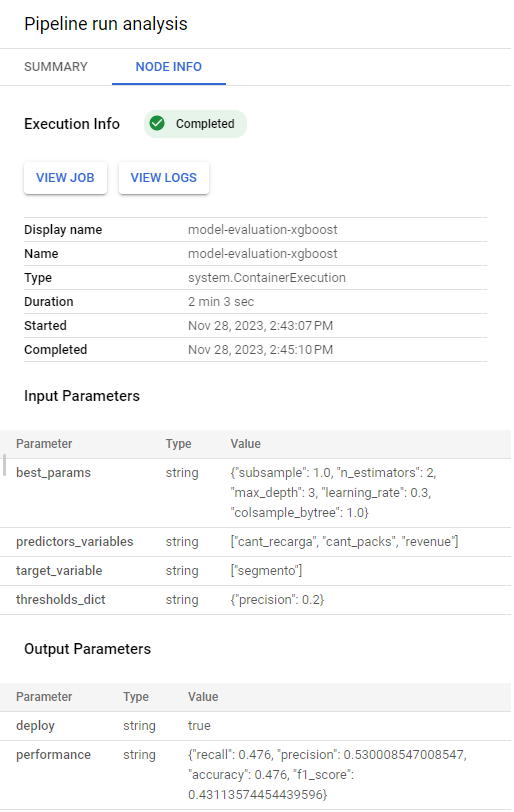

In [37]:
from IPython.display import Image
Image("img/model-evaluationxgboost.png")

## 4toa Componente - Deploy

In [28]:
# en el decorador se setea los parametros para crear el contendor
@component(
    packages_to_install=["google-cloud-aiplatform==1.26.1", "scikit-learn==1.2.0",  "kfp==1.8.22"],    
    base_image="python:3.9",
    #output_component_file="./artifacts/endpoint_component.yml"
)

def deploy_model(
    model: Input[Model],
    model_name:str,
    display_name: str,
    timestamp:str, 
    project: str,
    region: str,
    serving_container_image_uri : str, 
    vertex_model: Output[Model]

):

    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    import logging
    
    #Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = f"{display_name}_{timestamp}", 
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri =  serving_container_image_uri,
        serving_container_health_route=f"/v1/models/{model_name}",
        serving_container_predict_route=f"/v1/models/{model_name}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": model_name,
    },       
    )

    # Save data to the output params
    vertex_model.uri = model_upload.resource_name
    vertex_model.metadata["resource_name"] = model_upload.resource_name
    logging.info(f"MODEL RESOURCE NAME: {model_upload.resource_name}")
    

    
    

## 4tob Componente - Deploy Endpoint

In [27]:
@component(
    packages_to_install=["google-cloud-aiplatform==1.26.1", "scikit-learn==1.2.0",  "kfp==1.8.22"],
    base_image="python:3.9",
)
def deploy_model_endpoint(
    model: Input[Model],
    model_name:str,
    display_name: str,
    timestamp:str, 
    project: str,
    region: str,
    endpoint_config: dict,
    serving_container_image_uri : str, 
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model]
):
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    def create_endpoint():
        endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(endpoint_config.get("endpoint_name")),
        order_by='create_time desc',
        project=project, 
        location=region,
        )
        if len(endpoints) > 0:
            endpoint = endpoints[0]  # most recently created
        else:
            endpoint = aiplatform.Endpoint.create(
            display_name=endpoint_config.get("endpoint_name"), project=project, location=region
        )
    endpoint = create_endpoint()   
    
    
    #Import a model programmatically
    model_upload = aiplatform.Model.upload(
        display_name = f"{display_name}_{timestamp}", 
        artifact_uri = model.uri.replace("model", ""),
        serving_container_image_uri =  serving_container_image_uri,
        serving_container_health_route=f"/v1/models/{model_name}",
        serving_container_predict_route=f"/v1/models/{model_name}:predict",
        serving_container_environment_variables={
        "MODEL_NAME": model_name,
    },       
    )
    model_deploy = model_upload.deploy(
        machine_type=endpoint_config.get("machine_type"), 
        endpoint=endpoint,
        traffic_split={"0": 100},
        deployed_model_display_name=f"{display_name}_{timestamp}", 
    )

    # Save data to the output params
    vertex_model.uri = model_deploy.resource_name

Definamos el horario para trackear los experimentos

In [21]:
from datetime import datetime
timestamp =datetime.now().strftime("%Y%m%d%H%M%S")
display_name = 'pipeline-levantar-archivo-split-job{}'.format(timestamp)

Incluyamos todos los componentes dentro de un pipeline

In [32]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline. Use to determine the pipeline Context.
    name="pipeline-get-bq-split-train-test-deploy",
    
    
)
def armar_pipeline(
    #url: str = "https://storage.cloud.google.com/encuestas_nps/fake_data.csv", #Probar con cambiar la url
    query_string: str = """ 
    SELECT id, semana_encuesta, mes_encuesta, (case when segmento ='Detractor' then 1 else 0 end) as segmento, nps, cant_recarga, sum_recarga, cant_packs, revenue, mean_old_qoe, min_old_qoe
    FROM `project.sandbox.model_data` limit 1000
    """, 
    
    project: str = PROJECT_ID,
    region: str = REGION, 
    display_name: str = display_name,
    api_endpoint: str = REGION+"-aiplatform.googleapis.com",
    model_name: str = 'train_pipeline',
    model_version: str = "V1.0",
    serving_container_image_uri_sklearn: str = "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest",
    serving_container_image_uri_xgboost: str = "us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-7:latest", 
    ):
    #print(PROJECT_ID)
    dataset_task = get_dataframe_split(
        query_string = query_string,
        project_id= PROJECT_ID,

#        ).set_retry(num_retries=10,  # Número de reintentos
#        backoff_duration='1800s',  # Duración del retroceso individual
#        backoff_max_duration='60000s'  # Duración máxima del retroceso, un poco mayor
    )        
    train_model_task_sklearn = (train_sklearn(
        train_set = dataset_task.outputs["dataset_train"],
        predictors_variables = ['cant_recarga','cant_packs','revenue'],
        target_variable = ['segmento'],
        #dataset_format ="parquet",
        ).
    set_cpu_limit('5').  #standar 4
    set_memory_limit('16G')#. #standar 16G
    #  add_node_selector_constraint(label_name:"cloud.google.com/gke-accelerator",value: 'NVIDIA_TESLA_K80').
    # set_gpu_limit(1)
    )        
        
    test_model_task_sklearn = (test_sklearn(
            test_set = dataset_task.outputs["dataset_test"],
            model_trained=train_model_task_sklearn.outputs["model"],
            predictors_variables = ['cant_recarga','cant_packs','revenue'],
            target_variable = ['segmento'],
            thresholds_dict = {"precision" : 0.2} ,
        ).set_cpu_limit('5').set_memory_limit('16G')
    )
    
    train_model_task_xgboost = (train_xgboost(
        train_set = dataset_task.outputs["dataset_train"],
        predictors_variables = ['cant_recarga','cant_packs','revenue'],
        target_variable = ['segmento'],
        #dataset_format ="parquet",
        ).
    set_cpu_limit('5').  #standar 4
    set_memory_limit('16G')#. #standar 16G
    #  add_node_selector_constraint(label_name:"cloud.google.com/gke-accelerator",value: 'NVIDIA_TESLA_K80').
    # set_gpu_limit(1)
    )        
        
    test_model_task_xgboost = (test_xgboost(
            test_set = dataset_task.outputs["dataset_test"],
            model_trained=train_model_task_xgboost.outputs["model"],
            best_params=train_model_task_xgboost.outputs["best_params"],
            predictors_variables = ['cant_recarga','cant_packs','revenue'],
            target_variable = ['segmento'],
            thresholds_dict = {"precision" : 0.2} ,
        ).set_cpu_limit('5').set_memory_limit('16G')
    )

    with dsl.Condition(
        test_model_task_xgboost.outputs["deploy"]=="true" 
    ):
        deploy_model_op = deploy_model(
            model=train_model_task_xgboost.outputs["model"],
            model_name = model_name,
            display_name= display_name,
            timestamp = timestamp, 
            project = PROJECT_ID,
            region = REGION,
            serving_container_image_uri = serving_container_image_uri_xgboost, 
        )
    
    with dsl.Condition(
        test_model_task_sklearn.outputs["deploy"]=="true" 
    ):
        deploy_model_endpoint_op = deploy_model_endpoint(
            model=train_model_task_sklearn.outputs["model"],
            endpoint_config = {"machine_type": "n1-standard-2","traffic_split": 100,"endpoint_name": "model-V01"},
            model_name = model_name,
            display_name= display_name,
            timestamp = timestamp, 
            project = PROJECT_ID,
            region = REGION,
            serving_container_image_uri = serving_container_image_uri_sklearn, 
        )



In [33]:
compiler.Compiler().compile(pipeline_func=armar_pipeline,
        package_path='template-levantar-archivo-bq.json')  

start_pipeline = pipeline_jobs.PipelineJob(
    display_name="pipeline-levantar-archivo-bq",
    template_path="template-levantar-archivo-bq.json",
    enable_caching=True,
    location=REGION,
)

start_pipeline.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/242149956637/locations/us-central1/pipelineJobs/pipeline-get-bq-split-train-test-deploy-20231129223522
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/242149956637/locations/us-central1/pipelineJobs/pipeline-get-bq-split-train-test-deploy-20231129223522')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/pipeline-get-bq-split-train-test-deploy-20231129223522?project=242149956637
PipelineJob projects/242149956637/locations/us-central1/pipelineJobs/pipeline-get-bq-split-train-test-deploy-20231129223522 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/242149956637/locations/us-central1/pipelineJobs/pipeline-get-bq-split-train-test-deploy-20231129223522 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/242149956637/locations/us-central1/pipelineJobs/pipeline-get-bq-split-train-test-d